# Text Classification (Sentiment Analysis) using BERT

In [2]:
!pip install -U transformers wordcloud datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 108.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import gc

import torch
from torch import nn
from transformers import BertTokenizer, BertModel
from datasets import load_dataset

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

import os
import glob
import joblib
import random
import warnings
warnings.filterwarnings('ignore')


2025-07-11 03:10:43.813244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752203444.048278      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752203444.115570      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Extract IMDB Dataset

IMDB dataset from torchtext. It has training and testing data each with 25K records. The dataset is simple as it has two columns; label (or sentiment) and line (or review). Label 1 means Negative and Label 2 means Postive. We will change this to positive being 1 and negative being 0.

In [4]:
def load_imdb_data(): 
    dataset = load_dataset('imdb')

    train_data = dataset['train']
    df_train = pd.DataFrame(train_data)

    test_data = dataset['test']
    df_test = pd.DataFrame(test_data)

    return df_train, df_test

In [5]:
df_train, df_test = load_imdb_data()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
df_train.shape, df_test.shape

((25000, 2), (25000, 2))

## Exploratory Data Analysis

In [7]:
df_train.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [8]:
df_test.tail()

,text,label
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1
24999,I caught this movie on the Sci-Fi channel rece...,1


In [9]:
# Check if empty record

df_train.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
# Check duplicates

df_train.duplicated().sum()

96

In [11]:
# Drop duplicates

df_train = df_train.drop_duplicates(subset=['text'])

In [12]:
# Check the labels

df_train['label'].value_counts()

label
1    12472
0    12432
Name: count, dtype: int64

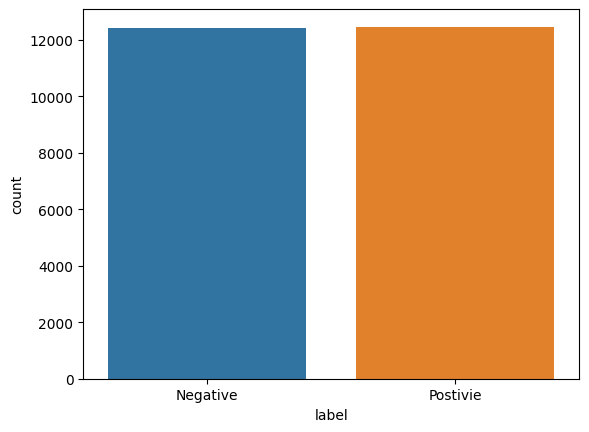

In [13]:
ax = sns.countplot(x='label', data=df_train)
ax.set_xticklabels(["Negative", "Postivie"])

plt.show()

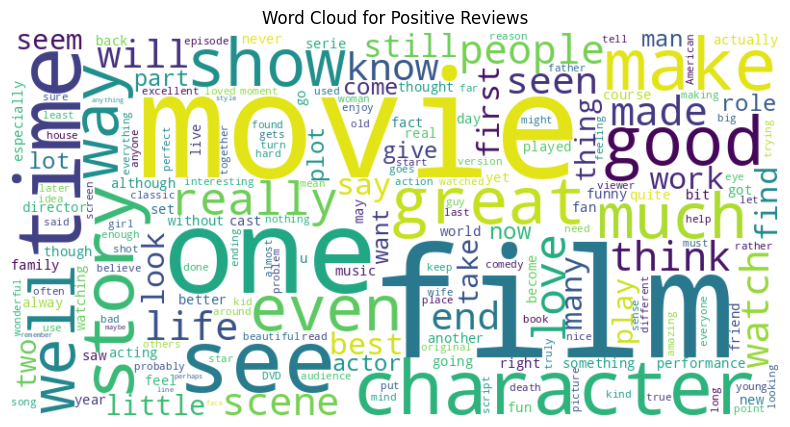

In [14]:
# Separate postive reviews

positive_reviews = df_train[df_train['label'] == 1]

# Join all reviews into one single string
positive_texts = " ".join(review.replace("br", "") for review in positive_reviews['text'])

stopwords = set(STOPWORDS)

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(positive_texts)

# Display positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

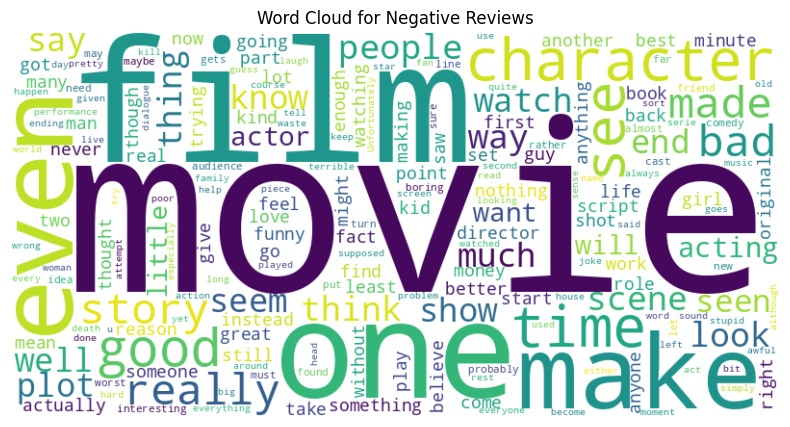

In [15]:
negative_reviews = df_train[df_train['label'] == 0]
negative_texts = " ".join(review.replace("br", "") for review in negative_reviews['text'])

wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)

# Display negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [16]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

print(device)

cuda


## Model 1: Pre-trained BERT model and Tokenizer

In [17]:
class SentimentBERT(nn.Module):
    def __init__(self, pretrained_model_name="bert-base-uncased"):
        super(SentimentBERT, self).__init__()
        self.bert_model = BertModel.from_pretrained(pretrained_model_name)
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

    def tokenize(self, texts):
        tokens = texts.apply(lambda x: self.tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))
        return tokens

    def pad_tokens(self, tokens, max_length=512):
        padded_tokens = np.array([i + [0] * (max_length - len(i)) for i in tokens.values])
        return padded_tokens
    
    def attention_mask(self, tokens):
        attention_mask = np.where(tokens != 0, 1, 0)
        return attention_mask

In [18]:
sentiment_bert = SentimentBERT().to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
batch_size = 32  # You can adjust this based on your GPU/CPU memory
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()

# Create a directory to store embeddings if it doesn't exist
embeddings_dir = 'imdb_train_embeddings'
if not os.path.exists(embeddings_dir):
    os.makedirs(embeddings_dir)

for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]

    # Tokenize and pad the batch
    tokenized = sentiment_bert.tokenize(pd.Series(batch_texts))
    padded_tokens = sentiment_bert.pad_tokens(tokenized)
    attention_mask = torch.tensor(sentiment_bert.attention_mask(padded_tokens)).to(device)

    input_ids = torch.tensor(padded_tokens).to(device)

    # Embed with BERT
    with torch.no_grad(): # Keep no_grad here as we are only generating embeddings
        outputs = sentiment_bert.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Save batch embeddings and labels to a file
    file_path = os.path.join(embeddings_dir, f'batch_{i//batch_size}.npz')
    np.savez(file_path, embeddings=cls_embeddings, labels=np.array(batch_labels))

    # Free up memory
    del tokenized, padded_tokens, attention_mask, input_ids, outputs, cls_embeddings
    torch.cuda.empty_cache()
    gc.collect()

print(f"Embeddings and labels saved to the '{embeddings_dir}' directory.")

100%|██████████| 779/779 [12:57<00:00,  1.00it/s]

Embeddings and labels saved to the 'imdb_train_embeddings' directory.


## Model 2: Logistic Regression for Classification

In [20]:
sgd_classifier = SGDClassifier(loss='log')

## Train for multiple epochs

In [44]:
npz_files = sorted(glob.glob(os.path.join(embeddings_dir, 'batch_*.npz')))
epochs = 5
classes = [0,1]

for epoch in tqdm(range(epochs)):
    random.shuffle(npz_files)

    for idx, file in enumerate(npz_files):
        data = np.load(file)
        embeddings = data['embeddings']
        labels = data['labels']

        # Train the classifier on the current batch
        if epoch == 0 and idx == 0:
            # Initialize the classifier with the first batch
            sgd_classifier.partial_fit(embeddings, labels, classes=classes)
        else:
            sgd_classifier.partial_fit(embeddings, labels)

# Save the model after each batch
joblib.dump(sgd_classifier, 'sgd_classifier.pkl')

100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


['sgd_classifier.pkl']

## Model Evaluation

Evaluate the logistic regression model on the test set using BERT features

In [22]:
test_batch_size = 32  # You can adjust this based on your GPU/CPU memory
test_texts = df_test['text'].tolist()
test_labels = df_test['label'].tolist()

test_embeddings_dir = 'imdb_test_embeddings'
if not os.path.exists(test_embeddings_dir):
    os.makedirs(test_embeddings_dir)

for i in tqdm(range(0, len(test_texts), test_batch_size)):
    test_batch_texts = test_texts[i:i+test_batch_size]

    # Tokenize and pad the batch
    test_tokenized = sentiment_bert.tokenize(pd.Series(test_batch_texts))
    test_padded_tokens = sentiment_bert.pad_tokens(test_tokenized)
    test_attention_mask = torch.tensor(sentiment_bert.attention_mask(test_padded_tokens)).to(device)

    test_input_ids = torch.tensor(test_padded_tokens).to(device)

    # Embed with BERT
    with torch.no_grad():
        test_outputs = sentiment_bert.bert_model(input_ids=test_input_ids, attention_mask=test_attention_mask)
        test_cls_embeddings = test_outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Save batch embeddings to a file
    test_file_path = os.path.join(test_embeddings_dir, f'test_batch_{i//test_batch_size}.npz')
    np.savez(test_file_path, embeddings=test_cls_embeddings, labels=np.array(test_labels[i:i+test_batch_size]))

    # Free up memory
    del test_tokenized, test_padded_tokens, test_input_ids, test_attention_mask, test_outputs, test_cls_embeddings
    torch.cuda.empty_cache()
    gc.collect()


100%|██████████| 782/782 [12:59<00:00,  1.00it/s]


## Testing from saved embeddings

In [45]:
test_embeddings_dir = 'imdb_test_embeddings'
test_npz_files = sorted(glob.glob(os.path.join(test_embeddings_dir, 'test_batch_*.npz')))

predicted = []
test_labels = []

for idx, file in tqdm(enumerate(test_npz_files)):
    data = np.load(file)
    embeddings = data['embeddings']
    labels = data['labels']
    test_labels.extend(labels)
    
    # Batch-wise test
    predicted.extend(sgd_classifier.predict(embeddings))

predicted = np.array(predicted)

782it [00:00, 1338.99it/s]


In [46]:
print(classification_report(test_labels, predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9830    0.2920    0.4503     12500
           1     0.5843    0.9950    0.7362     12500

    accuracy                         0.6435     25000
   macro avg     0.7836    0.6435    0.5932     25000
weighted avg     0.7836    0.6435    0.5932     25000



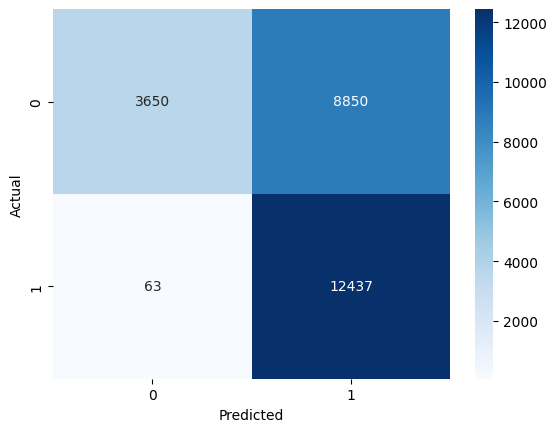

In [47]:
# Confusion matrix

cm = confusion_matrix(test_labels, predicted)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [48]:
# NULL Accuracy

highest_entity = max(df_test['label'].value_counts())

print(f"Null Accuracy: {highest_entity / df_test.shape[0]}")

Null Accuracy: 0.5


## Prediction

In [49]:
# Inference using the trained logistic regression model and BERT features

def infer_sentiment(review_text):
    # Tokenize, pad, and create attention mask for the input review
    tokens = sentiment_bert.tokenize(pd.Series([review_text]))
    padded = sentiment_bert.pad_tokens(tokens)
    attn_mask = torch.tensor(sentiment_bert.attention_mask(padded)).to(device)
    input_ids = torch.tensor(padded).to(device)

    with torch.no_grad():
        outputs = sentiment_bert.bert_model(input_ids=input_ids, attention_mask=attn_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Predict sentiment
    pred = sgd_classifier.predict(cls_embedding)[0]
    sentiment = "Positive" if pred == 1 else "Negative"
    return sentiment

In [62]:
example_review = "The movie was absolutely fantastic and I loved it!"
print(f"Review: {example_review}")
print(f"Predicted Sentiment: {infer_sentiment(example_review)}")

Review: The movie was absolutely fantastic and I loved it!
Predicted Sentiment: Positive
